In [1]:
%matplotlib inline

In [2]:
import pyathena as pa

In [2]:
import pyathena as pa
import pandas as pd
import xarray as xr
import glob
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Reading a history file:F:/yeongu//RPS_8pc_ICM1/hst/RPS_8pc_ICM1.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0139604 K / cm3 47936.0431923 K / cm3 34567.4920511 K / cm3 183.708541923 3.2576035238 solMass / pc2
245.0


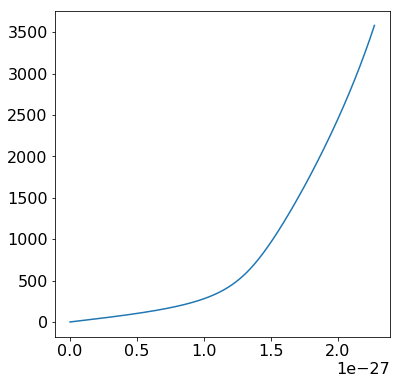

Reading a history file:F:/yeongu//RPS_8pc_ICM2/hst/RPS_8pc_ICM2.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0139604 K / cm3 47936.0431923 K / cm3 69134.9841023 K / cm3 1120.20799848 6.51520704759 solMass / pc2
245.0


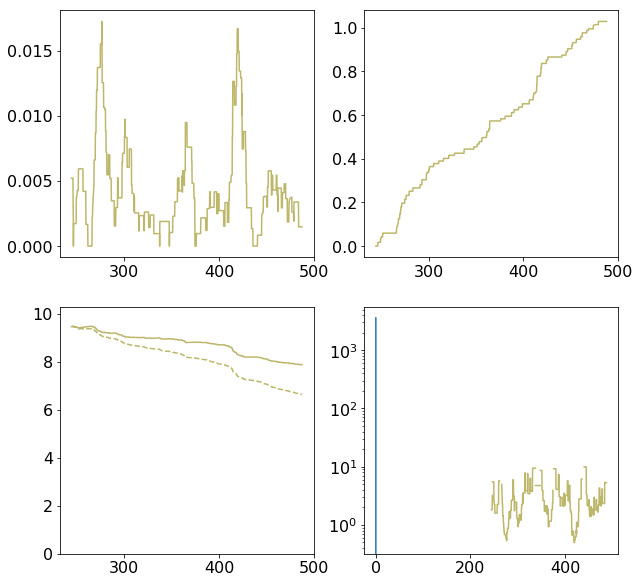

Reading a history file:F:/yeongu//RPS_8pc_ICM3/hst/RPS_8pc_ICM3.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0139604 K / cm3 47936.0431923 K / cm3 138311.738349 K / cm3 3583.0 13.034350469 solMass / pc2
245.0


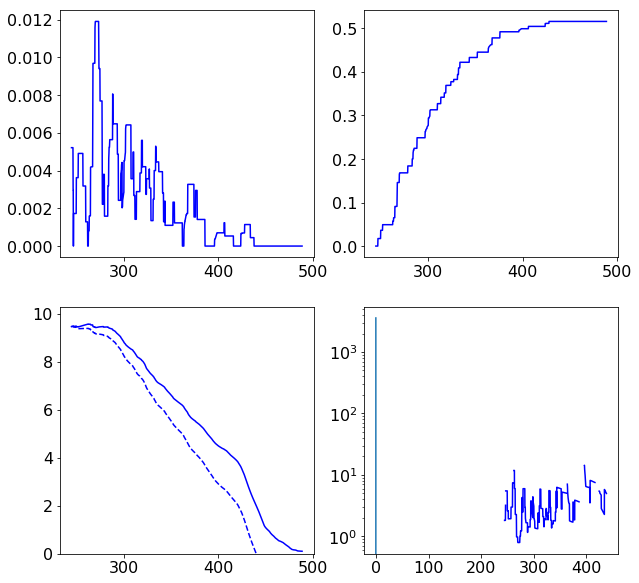

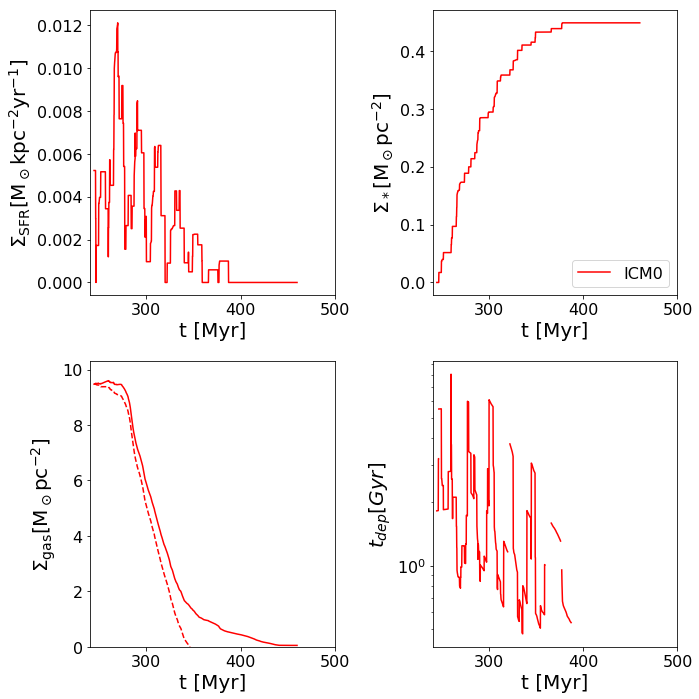

In [53]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.size']=16
import os,glob
labell = ('No ICM','P1', 'P3','P3h', 'P7','P7h','P14' ,'ICM1', 'ICM2', 'ICM3', 'ICM4')  # r'No ICM',
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM00','RPS_8pc_ICM0','RPS_8pc_ICM1','RPS_8pc_ICM2','RPS_8pc_ICM3','RPS_8pc_ICM4'] # '
base='G:/yeongu/'
C = ('k', 'salmon', 'mediumblue','deepskyblue' ,'darkgreen','lime', 'magenta','darkmagenta','goldenrod','royalblue','crimson')
plt.figure(figsize=(6, 6))
for j,problem_id in enumerate(ids[3:6]):
    rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    Myr=unit['time'].to('Myr').value
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    par=pa.get_params(parfile)
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    print c.G
    surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_ys=(hst.msp-hst.msp.iloc[0])*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_gas=np.interp(250,hst.time,surf)*u.M_sun/c.pc**2
    surf_star=par['SurfS']*u.M_sun/c.pc**2
    surf_dm=par['rhodm']*Lz*u.M_sun/c.pc**2
#    W1=2*np.pi*c.G*surf_gas*surf_star
#    W2=2*np.pi*c.G*surf_gas*surf_star
#    print (W1/c.k_B).cgs,(W2/c.k_B).cgs
    if par.has_key('d_icm'):
        z=np.arange(0,Lz/2.)
        gstar=2*np.pi*c.G*surf_star*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        W_star=(surf_gas*gstar/c.k_B).cgs
        W_dm=(surf_gas*gdm/c.k_B).cgs
        W=W_star+W_dm
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs
        z0=np.interp(Pram.value,W.value,z)
        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        print W_star[-1],W_dm[-1],Pram,z0,surf_crit
    #gg = gstar+gdm
    #print par['zstar']
    #plt.plot(gg.to('pc/s^2'),z)
    #plt.show()
    
    plt.subplot(221)
    l,=plt.plot(hst.sfr10,label=labels[j],color=C[j])

    plt.subplot(222)
    hst_later=hst.loc[250:500,:]
    sf=hst_later.sfr10.cumsum()*0.1*Myr
    l,=plt.plot(surf_ys,label=labels[j],color=C[j])
#plt.plot(surf_ys,color=l.get_color())

    plt.subplot(223)
    l,=plt.plot(surf,color=C[j])
    if par.has_key('d_icm'):        
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
        plt.plot(hst.time*Myr,surf.values.value-inflow_anal.values,color=C[j],ls='--')
        
        #plt.axhline(surf_crit.value,ls=':',color=l.get_color())
        #print 'd_icm', par['d_icm']*unit['density']
        #print 'v_icm', par['v_icm']*unit['velocity']
        #print inflow_anal
    plt.ylim(0,10.3)
    #plt.axvline(290,color='k')
    
    plt.subplot(224)
    l,=plt.semilogy(surf/hst.sfr10/1000,color=C[j])
    
    
axes=plt.gcf().axes
plt.setp(axes,'xlim',(240,500))
plt.setp(axes,'xlabel','t [Myr]')
plt.setp(axes[0],'ylabel',r'$\Sigma_{\rm SFR} [{\rm M_\odot kpc^{-2} yr^{-1}}]$')
plt.setp(axes[1],'ylabel',r'$\Sigma_{\rm *} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[2],'ylabel',r'$\Sigma_{\rm gas} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[3],'ylabel',r'$t_{dep} [Gyr]$')
axes[1].legend()
plt.tight_layout()
#plt.savefig('Histories_2.png',dpi=500)
plt.show()

Reading a history file:G:/yeongu//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p
[nan  0.  0. ...  0.  0.  0.] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 0.0 K / cm3 0.0 0.0 solMass / pc2


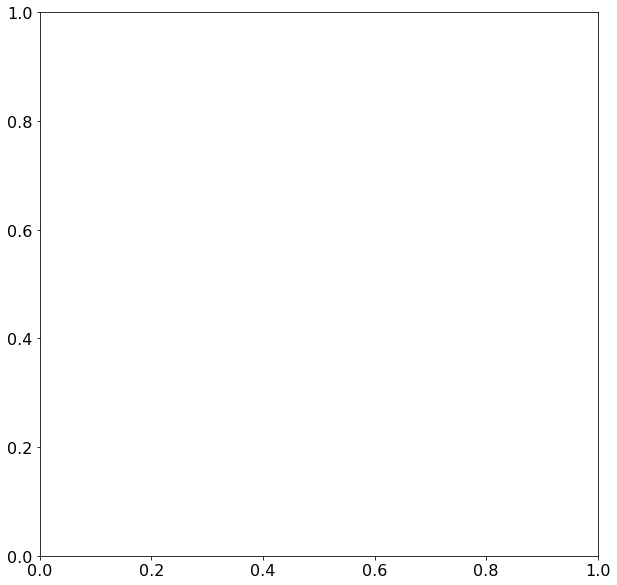

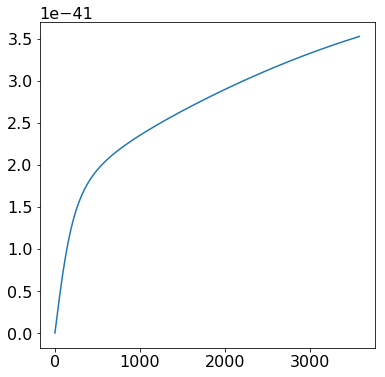

Reading a history file:G:/yeongu//RPS_8pc_ICM0_newacc/hst/RPS_8pc_ICM0_newacc.hst.p
[         inf 354.20853652 177.10838697 ...   0.81479248   0.81471967
   0.8146469 ] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 8644.48364684 K / cm3 37.80383821025001 0.814646904314 solMass / pc2


C:\anaconda2\lib\site-packages\ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


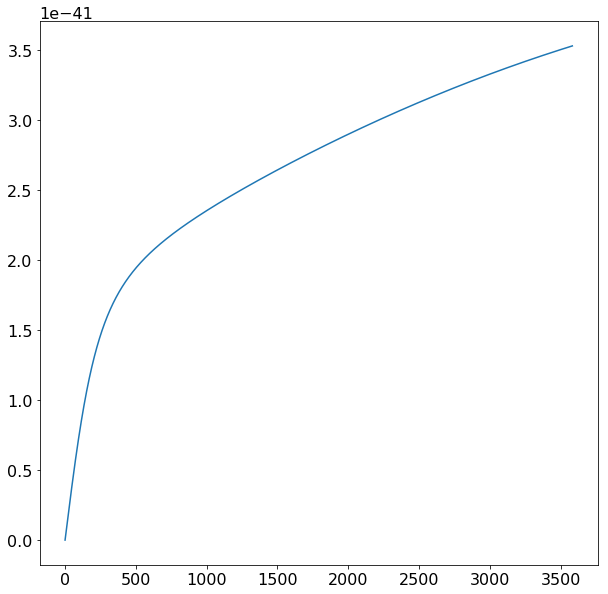

Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
[          inf 1416.40626216  708.21960095 ...    3.25818564    3.25789451
    3.25760352] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853082979974 3.2576035238 solMass / pc2


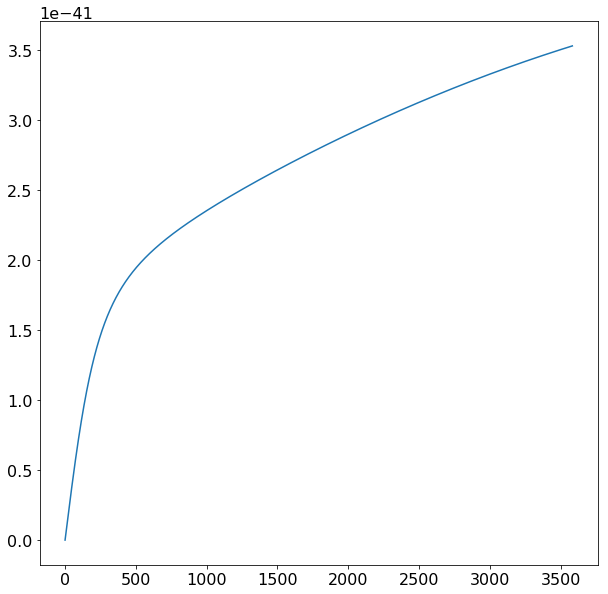

Reading a history file:G:/yeongu//RPS_4pc_ICM1_newacc/hst/RPS_4pc_ICM1_newacc.hst.p
[          inf 1416.40626216  708.21960095 ...    3.25818564    3.25789451
    3.25760352] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853082979636 3.2576035238 solMass / pc2


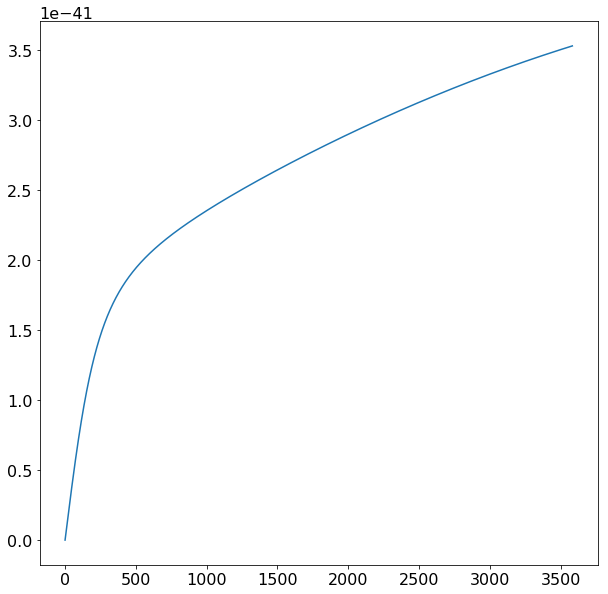

Reading a history file:G:/yeongu//RPS_8pc_ICM2_newacc/hst/RPS_8pc_ICM2_newacc.hst.p
[          inf 2832.81252432 1416.43920191 ...    6.51637128    6.51578902
    6.51520705] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 69134.9841023 K / cm3 1120.2078359340126 6.51520704759 solMass / pc2


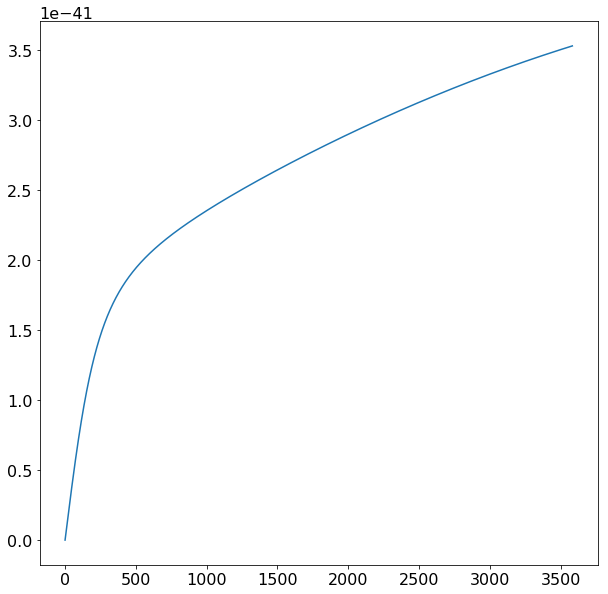

Reading a history file:G:/yeongu//RPS_4pc_ICM2_newacc/hst/RPS_4pc_ICM2_newacc.hst.p
[          inf 2832.81252432 1416.43920191 ...    6.51637128    6.51578902
    6.51520705] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 69134.9841023 K / cm3 1120.2078359339625 6.51520704759 solMass / pc2


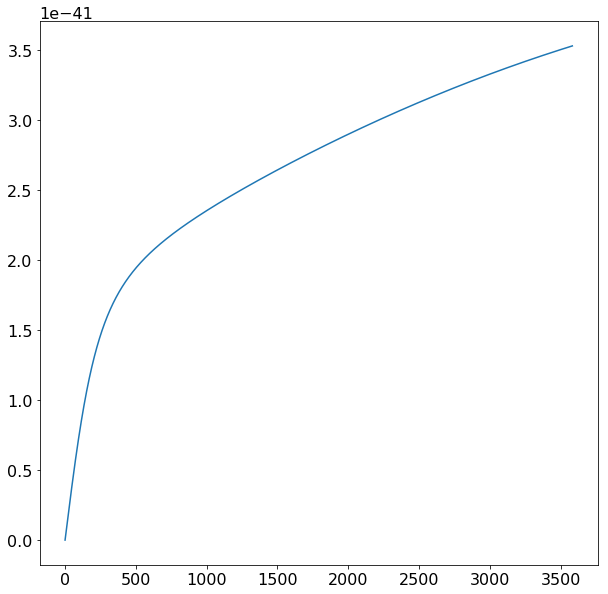

Reading a history file:G:/yeongu//RPS_8pc_ICM3_newacc/hst/RPS_8pc_ICM3_newacc.hst.p
[          inf 5667.33658428 2833.73419155 ...   13.03667964   13.03551476
   13.03435047] solMass / pc2
(3584L,)
52582.0160923 K / cm3 47936.0451358 K / cm3 138311.738349 K / cm3 3583.0 13.034350469 solMass / pc2


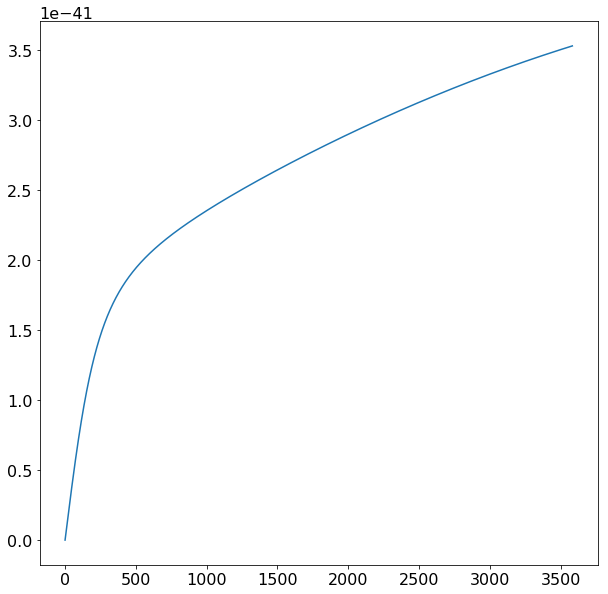

"\n    l,=plt.plot(surf,color=C[j],label='%s' % labels[j])\n    if par.has_key('d_icm'):        \n        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value\n        #print inflow_anal\n        #plt.plot(hst.time*Myr,surf.values.value-inflow_anal.values,color=C[j],ls='--')\n        #if j!=0:\n        #    plt.axhline(surf_crit.value,ls=':',color=l.get_color(),label=r'%s $\\Sigma_{crit}$' % labels[j])\n        #print 'd_icm', par['d_icm']*unit['density']\n        #print 'v_icm', par['v_icm']*unit['velocity']\n        #print inflow_anal\n\n    plt.ylim(1.e-3,20)\nplt.xlim(250*Myr,499*Myr)\n#plt.xticks(fontsize=30)\nplt.xlabel('time [Myr]',fontsize=17)\nplt.ylim(8,10)\n#plt.yticks(fontsize=30)\nplt.ylabel(r'$\\Sigma_{\rm gas}  [{\rm M_\\odot pc^{-2}}]$',fontsize=21)\n\nplt.legend(fontsize=17)\n\nplt.setp(axes[0],'ylabel',r'$\\Sigma_{\rm SFR} [{\rm M_\\odot kpc^{-2} yr^{-1}}]$')\nplt.setp(axes[1],'ylabel',

In [17]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.size']=16
import os,glob
#labels=['noICM','noICM_new','ICM1','ICM1_new','ICM2','ICM2_new'] # ['no ICM','ICM00','ICM0']#,'ICM00','ICM0',,'ICM2','ICM3','ICM4'
#ids=['R8_8pc_metal','RPS_8pc_noICM_newacc','RPS_8pc_ICM1','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2','RPS_8pc_ICM2_newacc']
labels=['noICM','ICM1','ICM2'] # ['no ICM','ICM00','ICM0']#,'ICM00','ICM0',,'ICM2','ICM3','ICM4'
labels=['No ICM','P1','P3','P3h','P7','P7h','P14']
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM0_newacc','RPS_8pc_ICM1_newacc','RPS_4pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_4pc_ICM2_newacc','RPS_8pc_ICM3_newacc'] #,'RPS_4pc_ICM1_newacc'
base='G:/yeongu/'

#C = ('darkkhaki','b','r','k','g','magenta','cyan') # 
#C = ('salmon','r','deepskyblue','b','limegreen','g')
C = ('dimgray', 'lightskyblue', 'dodgerblue','mediumblue' ,'goldenrod','salmon', 'firebrick')
plt.figure(figsize=(6, 6))
for j,problem_id in enumerate(ids):
    #rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    #rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    Myr=unit['time'].to('Myr').value
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    par=pa.get_params(parfile)
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']

    surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_ys=(hst.msp-hst.msp.iloc[0])*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_gas=np.interp(250,hst.time,surf)*u.M_sun/c.pc**2
    surf_star=par['SurfS']*u.M_sun/c.pc**2
    surf_dm=par['rhodm']*Lz*u.M_sun/c.pc**2
#    W1=2*np.pi*c.G*surf_gas*surf_star
#    W2=2*np.pi*c.G*surf_gas*surf_star
#    print (W1/c.k_B).cgs,(W2/c.k_B).cgs
    if par.has_key('d_icm'):
        z=np.arange(0,Lz/2.)
        gstar=2*np.pi*c.G*surf_star*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        W_star=(surf_gas*gstar/c.k_B).cgs
        W_dm=(surf_gas*gdm/c.k_B).cgs
        W=W_star+W_dm
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs
        z0=np.interp(Pram.value,W.value,z)
        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        surf_crit2=(Pram/(gstar+gdm)*c.k_B).to('M_sun/pc^2')
        print surf_crit2
        print surf_crit2.shape
        print W_star[-1],W_dm[-1],Pram,z0,surf_crit
    #plt.semilogy(surf_crit2,c=C[j],label='%s' % labels[j])
    plt.plot(gstar+gdm)
    plt.show()
    plt.hold(True) 
'''
    l,=plt.plot(surf,color=C[j],label='%s' % labels[j])
    if par.has_key('d_icm'):        
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
        #print inflow_anal
        #plt.plot(hst.time*Myr,surf.values.value-inflow_anal.values,color=C[j],ls='--')
        #if j!=0:
        #    plt.axhline(surf_crit.value,ls=':',color=l.get_color(),label=r'%s $\Sigma_{crit}$' % labels[j])
        #print 'd_icm', par['d_icm']*unit['density']
        #print 'v_icm', par['v_icm']*unit['velocity']
        #print inflow_anal

    plt.ylim(1.e-3,20)
plt.xlim(250*Myr,499*Myr)
#plt.xticks(fontsize=30)
plt.xlabel('time [Myr]',fontsize=17)
plt.ylim(8,10)
#plt.yticks(fontsize=30)
plt.ylabel(r'$\Sigma_{\rm gas}  [{\rm M_\odot pc^{-2}}]$',fontsize=21)

plt.legend(fontsize=17)

plt.setp(axes[0],'ylabel',r'$\Sigma_{\rm SFR} [{\rm M_\odot kpc^{-2} yr^{-1}}]$')
plt.setp(axes[1],'ylabel',r'$\Sigma_{\rm *} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[2],'ylabel',r'$\Sigma_{\rm gas} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[3],'ylabel',r'$\Sigma_{\rm out/in} [{\rm M_\odot pc^{-2}}]$')

#axes[1].legend()
plt.tight_layout()
#plt.savefig('D:/yeongu/plots/paperplot/new/surf_history_new.png',dpi=300)
#plt.savefig('D:/yeongu/plots/surf_history_new.eps',format='eps')
plt.show()
'''

Reading a history file:G:/yeongu//Rps_8pc_noICM_newacc/hst/Rps_8pc_noICM_newacc.hst.p
52582.0160923 K / cm3 47936.0451358 K / cm3 0.0 K / cm3 0.0 0.0 solMass / pc2
0.0 0.0
9.47271471062 solMass / pc2 8.59294727029 solMass / pc2
0.801508822838 solMass / pc2
Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853083 3.2576035238 solMass / pc2
0.0004985919588644997 1.2319955350250853
9.47271471062 solMass / pc2 8.89536172704 solMass / pc2
1.20109707341 solMass / pc2
Reading a history file:G:/yeongu//RPS_4pc_ICM1_newacc/hst/RPS_4pc_ICM1_newacc.hst.p
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853083 3.2576035238 solMass / pc2
0.0005000624066159841 1.2467306652469063
9.47271471062 solMass / pc2 8.47400924049 solMass / pc2
1.16270273003 solMass / pc2
Reading a history file:G:/yeongu//RPS_8pc_ICM2_newacc/hst/RPS_8pc_ICM2_newacc.hst.p
52582.0160923 K / cm3 47936.0

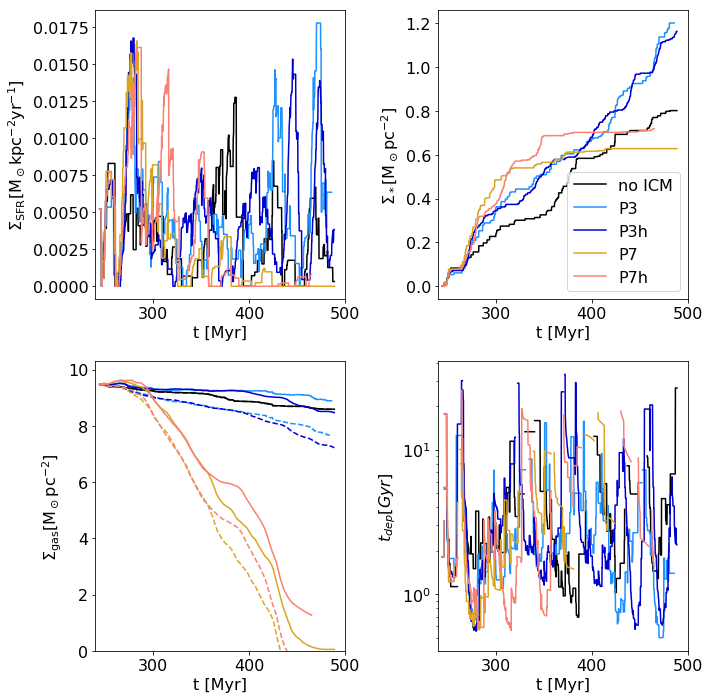

In [24]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.size']=16
import os,glob
labels=['no ICM','P3','P3h','P7','P7h'] # ['no ICM','ICM00','ICM0']#
ids=['Rps_8pc_noICM_newacc','RPS_8pc_ICM1_newacc','RPS_4pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_4pc_ICM2_newacc'] # '
base='G:/yeongu/'
C = ('k',  'dodgerblue','mediumblue' ,'goldenrod','salmon', 'firebrick')
for j,problem_id in enumerate(ids):
    rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    Myr=unit['time'].to('Myr').value
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    par=pa.get_params(parfile)
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    #print c.G
    surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_ys=(hst.msp-hst.msp.iloc[0])*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_gas=np.interp(250,hst.time,surf)*u.M_sun/c.pc**2
    surf_star=par['SurfS']*u.M_sun/c.pc**2
    surf_dm=par['rhodm']*Lz*u.M_sun/c.pc**2
#    W1=2*np.pi*c.G*surf_gas*surf_star
#    W2=2*np.pi*c.G*surf_gas*surf_star
#    print (W1/c.k_B).cgs,(W2/c.k_B).cgs
    if par.has_key('d_icm'):
        z=np.arange(0,Lz/2.)
        gstar=2*np.pi*c.G*surf_star*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        W_star=(surf_gas*gstar/c.k_B).cgs
        W_dm=(surf_gas*gdm/c.k_B).cgs
        W=W_star+W_dm
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs
        z0=np.interp(Pram.value,W.value,z)
        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        print W_star[-1],W_dm[-1],Pram,z0,surf_crit
    #gg = gstar+gdm
    #print par['zstar']
    #plt.plot(gg.to('pc/s^2'),z)
    #plt.show()
    
    plt.subplot(221)
    l,=plt.plot(hst.sfr10,label=labels[j],color=C[j])

    plt.subplot(222)
    hst_later=hst.loc[250:500,:]
    sf=hst_later.sfr10.cumsum()*0.1*Myr
    l,=plt.plot(surf_ys,label=labels[j],color=C[j])
    #l,=plt.plot(sf/Mytr,c='m')
#plt.plot(surf_ys,color=l.get_color())

    plt.subplot(223)
    l,=plt.plot(surf,color=C[j])
    if par.has_key('d_icm'):        
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
        plt.plot(hst.time*Myr,surf.values.value-inflow_anal.values,color=C[j],ls='--')
        
        #plt.axhline(surf_crit.value,ls=':',color=l.get_color())
        #print 'd_icm', par['d_icm']*unit['density']
        #print 'v_icm', par['v_icm']*unit['velocity']
        print inflow_anal.values[1], inflow_anal.values[-1]
        print surf.values[0], surf.values[-1]
        print surf_ys.values[-1]
        
    plt.ylim(0,10.3)
    #plt.axvline(290,color='k')
    
    plt.subplot(224)
    l,=plt.semilogy(surf/hst.sfr10/1000,color=C[j])
    
    
axes=plt.gcf().axes
plt.setp(axes,'xlim',(240,500))
plt.setp(axes,'xlabel','t [Myr]')
plt.setp(axes[0],'ylabel',r'$\Sigma_{\rm SFR} [{\rm M_\odot kpc^{-2} yr^{-1}}]$')
plt.setp(axes[1],'ylabel',r'$\Sigma_{\rm *} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[2],'ylabel',r'$\Sigma_{\rm gas} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[3],'ylabel',r'$t_{dep} [Gyr]$')
axes[1].legend()
plt.tight_layout()
#plt.savefig('Histories_2.png',dpi=500)
plt.show()

In [12]:
MFunit=(unit['density']*unit['velocity']).to('Msun/pc^2/Myr').value
Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value

In [20]:
z=np.arange(0,Lz/2.)
print(Lz)
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
print(Myr)

7168.0
0.977792221673


Reading a history file:G:/yeongu//RPS_8pc_ICM0_newacc/hst/RPS_8pc_ICM0_newacc.hst.p
8644.48364684 K / cm3
[100518.06122808 100521.46009171 100524.40085578 ...  90785.87376641
  90786.54567717  90787.14239333]
Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
34567.4920511 K / cm3
[100518.06122808 100524.76205151 100531.28921649 ...  94390.85104743
  94391.17490362  94391.58066506]
Reading a history file:G:/yeongu//RPS_8pc_ICM2_newacc/hst/RPS_8pc_ICM2_newacc.hst.p
69134.9841023 K / cm3
[100518.06122808 100530.0824645  100542.05621041 ...    535.50882206
    535.50881334    535.50880461]
Reading a history file:G:/yeongu//RPS_8pc_ICM3_newacc/hst/RPS_8pc_ICM3_newacc.hst.p
138311.738349 K / cm3
[100518.06122808 100534.33706436 100550.84677583 ...    536.03162089
    536.03161955    536.03161945]


C:\anaconda2\lib\site-packages\matplotlib\contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


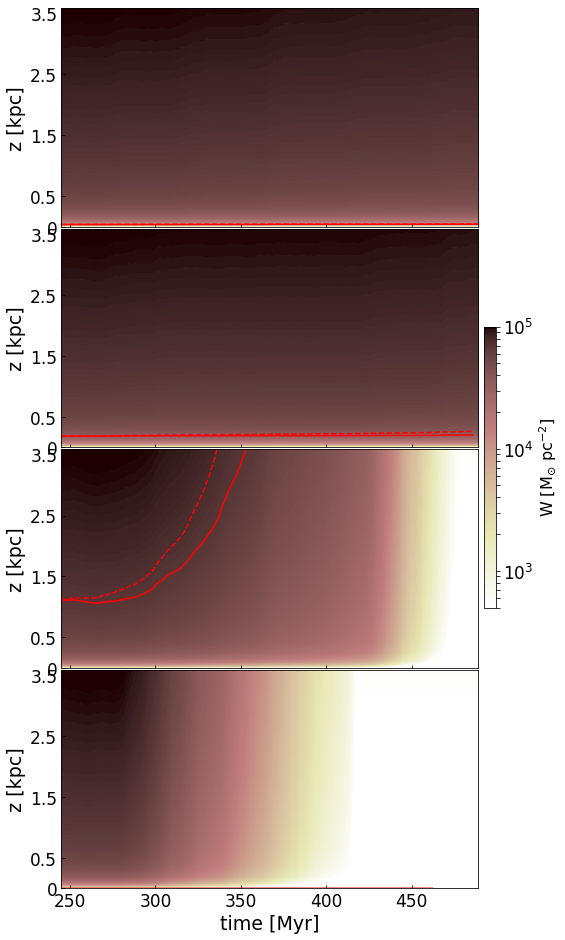

In [5]:
import astropy.constants as c
import astropy.units as u
i=1
#ids=['RPS_8pc_ICM1','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2','RPS_8pc_ICM2_newacc']
ids=['RPS_8pc_ICM0_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_8pc_ICM3_newacc']
labels = ['ICM1','ICM1_w/o_gas','ICM2','ICM2_w/o_gas']
plt.figure(figsize=(8,13)) # originally 13,5
plt.gcf().subplots_adjust(right=0.85)
plt.rcParams['font.size']=16

for j,problem_id in enumerate(ids):

    base='G:/yeongu/'
        
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    par=pa.get_params(parfile)
    if par.has_key('d_icm'):
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs # ram pressure
        print Pram
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2')
        Lz=par['x3max']-par['x3min'] # box size
        #print((hst.mass))
        surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
        #print(surf.shape)
        gstar=2*np.pi*c.G*par['SurfS']*u.M_sun/c.pc**2*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        '''
        print gstar+gdm
        xx = np.arange(0,len(gstar))
        plt.plot(xx,gstar+gdm)
        plt.show()
        plt.close()
        '''
        #print surf[np.newaxis,:].shape
        W2d=np.array((surf[np.newaxis,:]*(gstar+gdm)[:,np.newaxis]/c.k_B).cgs)
        print W2d[-1,:]
        #print(W2d.shape)
        dsurf=surf-inflow_anal # surface density - ICM inflow
        W2d_gas=np.array((dsurf[np.newaxis,:]*(gstar+gdm)[:,np.newaxis]/c.k_B).cgs)
        '''
        if i==1 or i==2:
            m = 1
        else:
            m = 2
        if i==1 or i==3:
            cc = 'b' # old
        else:
            cc = 'r' # new
        plt.subplot(2,1,m)
        im=plt.imshow(W2d,cmap='pink_r',origin='lower',extent=[250,500,0,Lz/2],aspect='auto',norm=LogNorm(vmin=5.e2,vmax=1.e5))
        cs=plt.contour(hst.time,z,W2d,[Pram.value],colors=cc)
        cs=plt.contour(hst.time,z,W2d_gas,[Pram.value],colors=cc,linestyles='--')
        '''
        
        plt.subplot(4,1,i)
        im=plt.imshow(W2d,cmap='pink_r',origin='lower',extent=[250,500,0,Lz/2],aspect='auto',norm=LogNorm(vmin=5.e2,vmax=1.e5))
        cs=plt.contour(hst.time,z,W2d,[Pram.value],colors='r')
        cs=plt.contour(hst.time,z,W2d_gas,[Pram.value],colors='r',linestyles='--')
        #plt.clabel(cs, fontsize=9, inline=1)

        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        #print inflow_anal,surf_crit,Pram
        #plt.xticks([250*(2-Myr),300*(2-Myr),350*(2-Myr),400*(2-Myr),450*(2-Myr)],[250,300,350,400,450],fontsize=17)
        #plt.xlabel(r'time [Myr]',fontsize=19)
        plt.yticks([0,500,1500,2500,3500],[0,0.5,1.5,2.5,3.5],fontsize=17)
        plt.ylabel(r'z [kpc]',fontsize=19)
        if i==4:
            plt.xticks([250*(2-Myr),300*(2-Myr),350*(2-Myr),400*(2-Myr),450*(2-Myr)],[250,300,350,400,450],fontsize=17)
            plt.xlabel(r'time [Myr]',fontsize=19)
        else :
            plt.xticks([250*(2-Myr),300*(2-Myr),350*(2-Myr),400*(2-Myr),450*(2-Myr)],[])
        '''
        aa = 5.5194
        if i==1 or i==2 or i==3:
            plt.xticks([250+aa,300+aa,350+aa,400+aa,450+aa],[])
        else:
            plt.xticks([250+aa,300+aa,350+aa,400+aa,450+aa],[250,300,350,400,450])
        if i==4 or i==5 or i==6:
            plt.xlabel(r'time [Myr]',fontsize=15)
        if i==1 or i==4:    
            plt.ylabel(r'z [kpc]',fontsize=17)
            plt.yticks([0,500,1500,2500,3500],[0,0.5,1.5,2.5,3.5])
        else:
            plt.yticks([0,500,1500,2500,3500],[])
        '''    
        #plt.title('%s' % problem_id)
        #if i==3 or i==6:
        #    plt.colorbar(im,label=r'W [M$_{\odot}$ pc$^{-2}$]')
        plt.tick_params(direction='in')
        #plt.legend(loc=0)
        i=i+1

cbar_ax = plt.gcf().add_axes([0.86, 0.35, 0.02, 0.3])
cbar = plt.colorbar(im,cax=cbar_ax,label=r'W [M$_{\odot}$ pc$^{-2}$]')
cbar.ax.tick_params(labelsize=19)
#cbar = plt.colorbar(im,cax=,label=r'W [M$_{\odot}$ pc$^{-2}$]')
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=17)

#cbar_ax = plt.add_axes([0.85, 0.2, 0.03, 0.75]) 
#plt.colorbar(im, cax=cbar_ax) 
#cbar_ax.set_ylabel('color level') 
#plt.subplots_adjust(left=0.05, bottom=0.2, right=0.8, top=0.95, wspace=0.2, hspace=0.2) 
#plt.tight_layout()
#plt.legend(loc=0)
plt.subplots_adjust(bottom=0.05,top=0.99,hspace = .01)
#plt.savefig('G&G_condition.png',dpi=300)
#plt.savefig('G&G_condition.eps', format='eps')
plt.show()

In [37]:
import pandas as pd
for i in range(270,271):
    surfnames=[]
    for problem_id in ids:
        surfname='%s/%s/surf/%s.%04d.surf.p' % (base,problem_id,problem_id,i)
        scalname='%s/%s/surf/%s.%04d.scal0.p' % (base,problem_id,problem_id,i)
        surf=pd.read_pickle(surfname)
        data=surf['z']['data']
        plt.hist(np.log10(data.flat),range=[-2,2],bins=50,label=problem_id,histtype='step',lw=2)
        if os.path.isfile(scalname): 
            scal=pd.read_pickle(scalname)
            data2=scal['z']['data']
            icm_area=(data2>0.1).sum()
            icm_frac=icm_area/128./128.
            print icm_frac
            plt.axhline(icm_frac)
        plt.axvline(np.log10(surf_crit.value),linestyle=':',color='C2')
        plt.axvline(np.log10(surf_crit.value/2),linestyle=':',color='C1')
#        plt.axvline(np.log10(surf_crit.value/4))
        print problem_id,(data<surf_crit.value).sum()/128./128.,(data<surf_crit.value/2).sum()/128./128.
plt.legend()

IOError: [Errno 2] No such file or directory: 'D:/yeongu/R8_8pc_metal/surf/R8_8pc_metal.0270.surf.p'

Reading a history file:G:/yeongu//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 0.0 K / cm3 0.0 0.0 solMass / pc2
245.0


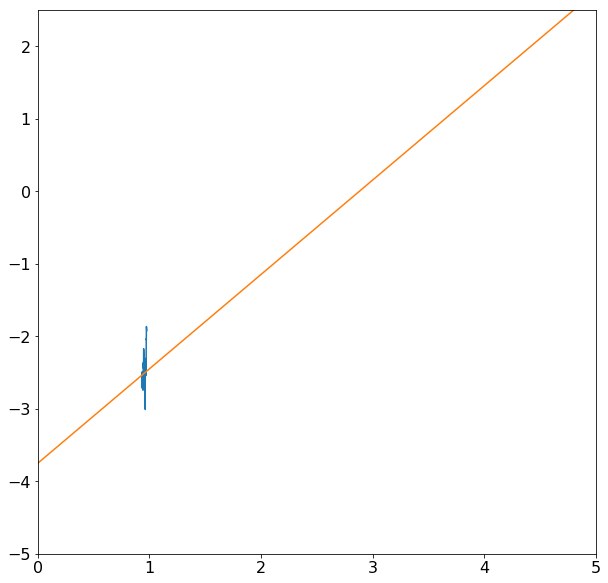

Reading a history file:G:/yeongu//RPS_8pc_ICM0_newacc/hst/RPS_8pc_ICM0_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 8644.48364684 K / cm3 37.80383821025001 0.814646904314 solMass / pc2
245.0


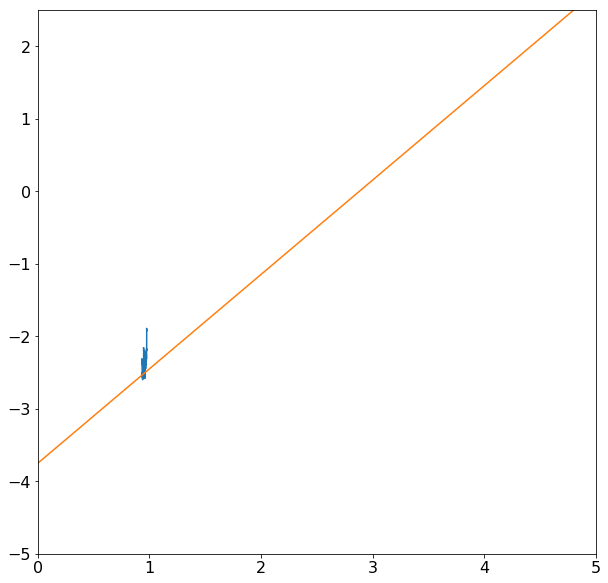

Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853082979974 3.2576035238 solMass / pc2
245.0


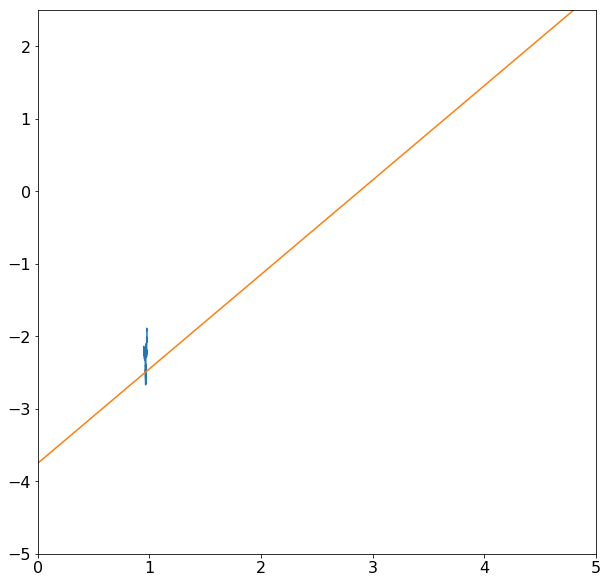

Reading a history file:G:/yeongu//RPS_4pc_ICM1_newacc/hst/RPS_4pc_ICM1_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 34567.4920511 K / cm3 183.70853082979636 3.2576035238 solMass / pc2
245.0


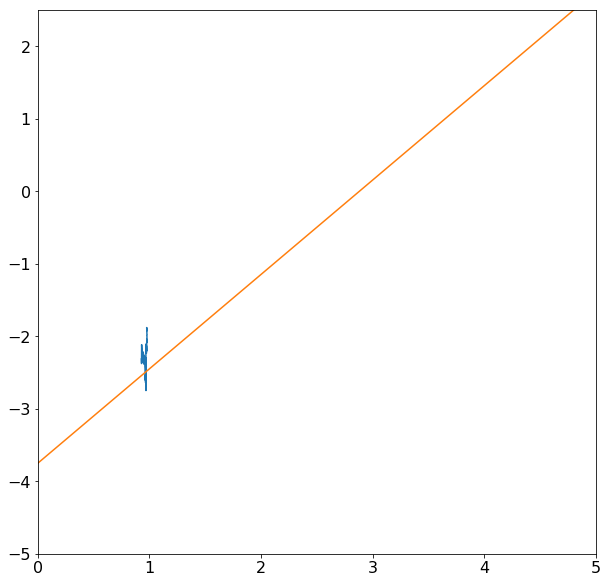

Reading a history file:G:/yeongu//RPS_8pc_ICM2_newacc/hst/RPS_8pc_ICM2_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 69134.9841023 K / cm3 1120.2078359340126 6.51520704759 solMass / pc2
245.0


C:\anaconda2\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


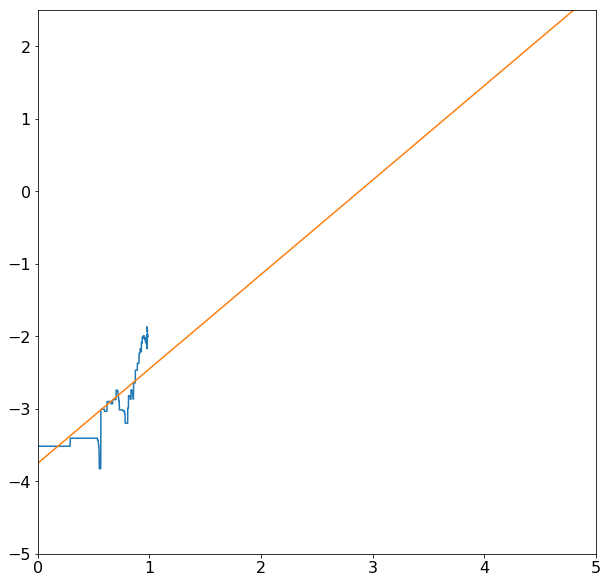

Reading a history file:G:/yeongu//RPS_4pc_ICM2_newacc/hst/RPS_4pc_ICM2_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 69134.9841023 K / cm3 1120.2078359339625 6.51520704759 solMass / pc2
245.0


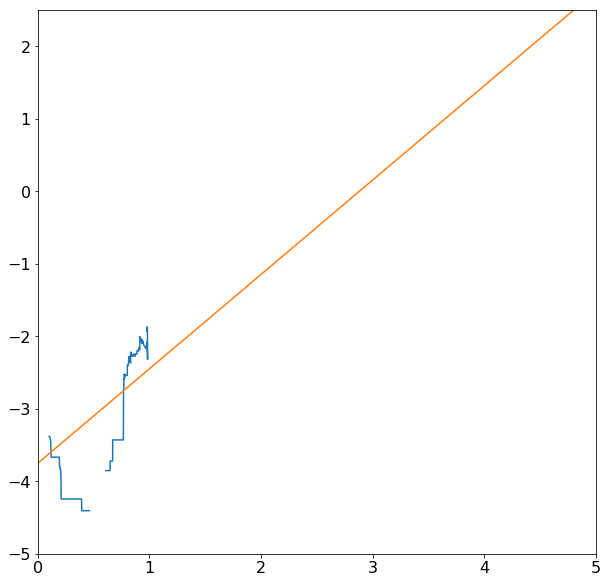

Reading a history file:G:/yeongu//RPS_8pc_ICM3_newacc/hst/RPS_8pc_ICM3_newacc.hst.p
  Name   = Gravitational constant
  Value  = 6.67408e-11
  Uncertainty  = 3.1e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2014
52582.0160923 K / cm3 47936.0451358 K / cm3 138311.738349 K / cm3 3583.0 13.034350469 solMass / pc2
245.0


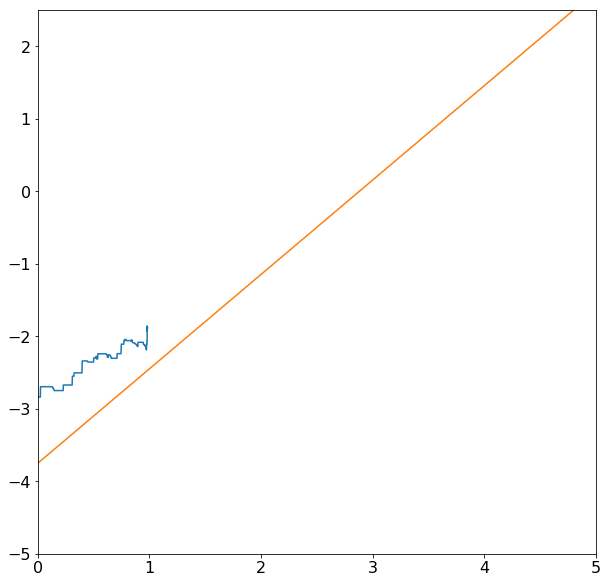

"    \naxes=plt.gcf().axes\nplt.setp(axes,'xlim',(240,500))\nplt.setp(axes,'xlabel','t [Myr]')\nplt.setp(axes[0],'ylabel',r'$\\Sigma_{\rm SFR} [{\rm M_\\odot kpc^{-2} yr^{-1}}]$')\nplt.setp(axes[1],'ylabel',r'$\\Sigma_{\rm *} [{\rm M_\\odot pc^{-2}}]$')\nplt.setp(axes[2],'ylabel',r'$\\Sigma_{\rm gas} [{\rm M_\\odot pc^{-2}}]$')\nplt.setp(axes[3],'ylabel',r'$t_{dep} [Gyr]$')\naxes[1].legend()\nplt.tight_layout()\n#plt.savefig('Histories_2.png',dpi=500)\nplt.show()\n"

In [16]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.size']=16
import os,glob
labels=['no ICM','ICM00','ICM0','ICM1','ICM2','ICM3','ICM4'] # ['no ICM','ICM00','ICM0']#
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM0_newacc','RPS_8pc_ICM1_newacc','RPS_4pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_4pc_ICM2_newacc','RPS_8pc_ICM3_newacc'] # '
base='G:/yeongu/'
C = ('darkkhaki','b','r','k','g','magenta','cyan') # 
for j,problem_id in enumerate(ids):
    rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    Myr=unit['time'].to('Myr').value
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    par=pa.get_params(parfile)
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    print c.G
    surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_ys=(hst.msp-hst.msp.iloc[0])*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
    surf_gas=np.interp(250,hst.time,surf)*u.M_sun/c.pc**2
    surf_star=par['SurfS']*u.M_sun/c.pc**2
    surf_dm=par['rhodm']*Lz*u.M_sun/c.pc**2
#    W1=2*np.pi*c.G*surf_gas*surf_star
#    W2=2*np.pi*c.G*surf_gas*surf_star
#    print (W1/c.k_B).cgs,(W2/c.k_B).cgs
    if par.has_key('d_icm'):
        z=np.arange(0,Lz/2.)
        gstar=2*np.pi*c.G*surf_star*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        W_star=(surf_gas*gstar/c.k_B).cgs
        W_dm=(surf_gas*gdm/c.k_B).cgs
        W=W_star+W_dm
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs
        z0=np.interp(Pram.value,W.value,z)
        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        print W_star[-1],W_dm[-1],Pram,z0,surf_crit
    gg = gstar+gdm
    print par['zstar']
    plt.plot(np.log10(surf),np.log10(hst.sfr40))
    plt.plot([0,4.8],[-3.75,2.5])
    plt.xlim(0,5)
    plt.ylim(-5,2.5)
    plt.show()
    '''
    plt.subplot(221)
    l,=plt.scatter(surf.value,hst.sfr10.value,label=labels[j],color=C[j])
        
    plt.subplot(222)
    hst_later=hst.loc[250:500,:]
    sf=hst_later.sfr10.cumsum()*0.1*Myr
    l,=plt.plot(surf_ys,label=labels[j],color=C[j])
#plt.plot(surf_ys,color=l.get_color())

    plt.subplot(223)
    l,=plt.plot(surf,color=C[j])
    if par.has_key('d_icm'):        
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
        plt.plot(hst.time*Myr,surf.values.value-inflow_anal.values,color=C[j],ls='--')
        
        #plt.axhline(surf_crit.value,ls=':',color=l.get_color())
        #print 'd_icm', par['d_icm']*unit['density']
        #print 'v_icm', par['v_icm']*unit['velocity']
        #print inflow_anal
    plt.ylim(0,10.3)
    #plt.axvline(290,color='k')
    
    plt.subplot(224)
    l,=plt.semilogy(surf/hst.sfr10/1000,color=C[j])
    '''
'''    
axes=plt.gcf().axes
plt.setp(axes,'xlim',(240,500))
plt.setp(axes,'xlabel','t [Myr]')
plt.setp(axes[0],'ylabel',r'$\Sigma_{\rm SFR} [{\rm M_\odot kpc^{-2} yr^{-1}}]$')
plt.setp(axes[1],'ylabel',r'$\Sigma_{\rm *} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[2],'ylabel',r'$\Sigma_{\rm gas} [{\rm M_\odot pc^{-2}}]$')
plt.setp(axes[3],'ylabel',r'$t_{dep} [Gyr]$')
axes[1].legend()
plt.tight_layout()
#plt.savefig('Histories_2.png',dpi=500)
plt.show()
'''

Reading a history file:G:/yeongu//RPS_8pc_ICM0_newacc/hst/RPS_8pc_ICM0_newacc.hst.p
8644.48364684 K / cm3
7168.0
[0.00000000e+00 7.55004907e-44 1.50997208e-43 ... 1.84546332e-41
 1.84546572e-41 1.84546812e-41] m solMass / (kg s2) 245.0 42.0 0.0064
[   0    1    2 ... 3581 3582 3583]


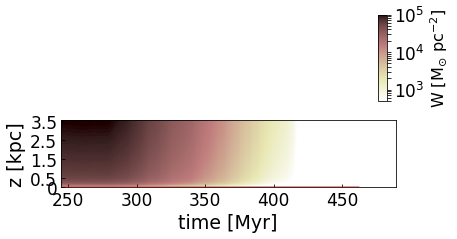

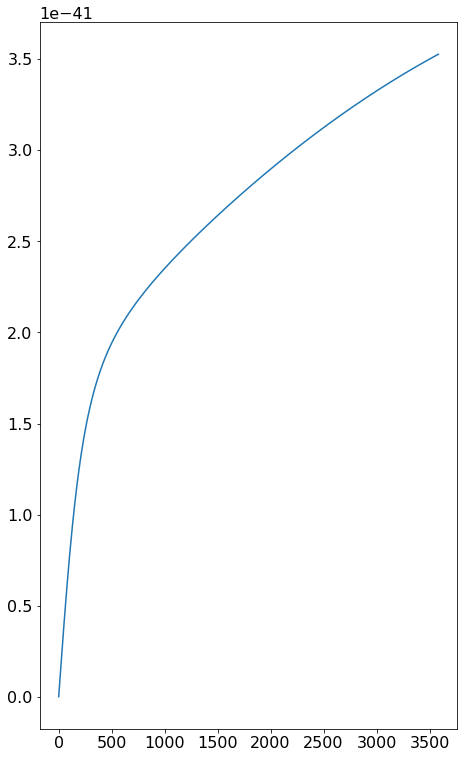

[     0.            231.18225273    462.35375302 ... 100500.10236395
 100509.08327921 100518.06122808]
(3584L, 2501L)
Reading a history file:G:/yeongu//RPS_4pc_ICM1_newacc/hst/RPS_4pc_ICM1_newacc.hst.p
34567.4920511 K / cm3
7168.0
[0.00000000e+00 7.55004907e-44 1.50997208e-43 ... 1.84546332e-41
 1.84546572e-41 1.84546812e-41] m solMass / (kg s2) 245.0 42.0 0.0064
[   0    1    2 ... 3581 3582 3583]


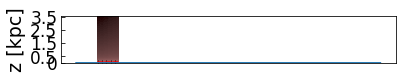

[     0.            231.18225273    462.35375302 ... 100500.10236395
 100509.08327921 100518.06122808]
(3584L, 2510L)
Reading a history file:G:/yeongu//RPS_4pc_ICM2_newacc/hst/RPS_4pc_ICM2_newacc.hst.p
69134.9841023 K / cm3
7168.0
[0.00000000e+00 7.55004907e-44 1.50997208e-43 ... 1.84546332e-41
 1.84546572e-41 1.84546812e-41] m solMass / (kg s2) 245.0 42.0 0.0064
[   0    1    2 ... 3581 3582 3583]


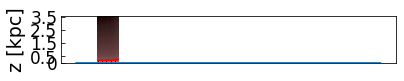

[     0.            231.18225273    462.35375302 ... 100500.10236395
 100509.08327921 100518.06122808]
(3584L, 2266L)
Reading a history file:G:/yeongu//RPS_8pc_ICM3_newacc/hst/RPS_8pc_ICM3_newacc.hst.p
138311.738349 K / cm3
7168.0
[0.00000000e+00 7.55004907e-44 1.50997208e-43 ... 1.84546332e-41
 1.84546572e-41 1.84546812e-41] m solMass / (kg s2) 245.0 42.0 0.0064
[   0    1    2 ... 3581 3582 3583]


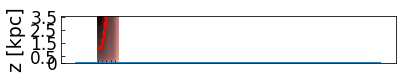

[     0.            231.18225273    462.35375302 ... 100500.10236395
 100509.08327921 100518.06122808]
(3584L, 2231L)


In [12]:
import astropy.constants as c
import astropy.units as u
i=1

from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
#print(Myr)
unit=pa.set_units(muH=1.4271)
#ids=['RPS_8pc_ICM1','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2','RPS_8pc_ICM2_newacc']
ids=['RPS_8pc_ICM0_newacc','RPS_4pc_ICM1_newacc','RPS_4pc_ICM2_newacc','RPS_8pc_ICM3_newacc']
labels = ['ICM1','ICM1_w/o_gas','ICM2','ICM2_w/o_gas']
plt.figure(figsize=(8,13)) # originally 13,5
plt.gcf().subplots_adjust(right=0.85)
plt.rcParams['font.size']=16
Myr=unit['time'].to('Myr').value
for j,problem_id in enumerate(ids):

    base='G:/yeongu/'
        
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    par=pa.get_params(parfile)
    if par.has_key('d_icm'):
        Pram=par['d_icm']*par['v_icm']**2*(unit['density']*unit['velocity']**2/c.k_B).cgs # ram pressure
        print Pram
        inflow_anal=(hst.time-hst.time.iloc[0])*par['d_icm']*par['v_icm']*(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2')
        Lz=par['x3max']-par['x3min'] # box size
        #print par['x3max']
        z=np.arange(0,Lz/2.)
        print(Lz)
        #print((hst.mass))
        surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
        #print(surf.shape)
        gstar=2*np.pi*c.G*par['SurfS']*u.M_sun/c.pc**2*z/np.sqrt(z**2+par['zstar']**2)
        gdm=4*np.pi*c.G*par['rhodm']*z/(1+(z/par['R0'])**2)*u.M_sun/c.pc**2
        print gstar, par['zstar'], par['SurfS'], par['rhodm']
        #print gstar+gdm
        xx = np.arange(0,len(gstar))
        print xx
        plt.plot(xx,gstar+gdm)
        plt.show()
        plt.close()

        #print surf[np.newaxis,:].shape
        W2d=np.array((surf[np.newaxis,:]*(gstar+gdm)[:,np.newaxis]/c.k_B).cgs)
        print W2d[:,0]
        print W2d.shape
        #print(W2d.shape)
        dsurf=surf-inflow_anal # surface density - ICM inflow
        W2d_gas=np.array((dsurf[np.newaxis,:]*(gstar+gdm)[:,np.newaxis]/c.k_B).cgs)
        '''
        if i==1 or i==2:
            m = 1
        else:
            m = 2
        if i==1 or i==3:
            cc = 'b' # old
        else:
            cc = 'r' # new
        plt.subplot(2,1,m)
        im=plt.imshow(W2d,cmap='pink_r',origin='lower',extent=[250,500,0,Lz/2],aspect='auto',norm=LogNorm(vmin=5.e2,vmax=1.e5))
        cs=plt.contour(hst.time,z,W2d,[Pram.value],colors=cc)
        cs=plt.contour(hst.time,z,W2d_gas,[Pram.value],colors=cc,linestyles='--')
        '''
        
        plt.subplot(4,1,i)
        im=plt.imshow(W2d,cmap='pink_r',origin='lower',extent=[250,500,0,Lz/2],aspect='auto',norm=LogNorm(vmin=5.e2,vmax=1.e5))
        cs=plt.contour(hst.time,z,W2d,[Pram.value],colors='r')
        cs=plt.contour(hst.time,z,W2d_gas,[Pram.value],colors='r',linestyles='--')
        #plt.clabel(cs, fontsize=9, inline=1)

        surf_crit=(Pram/(gstar+gdm)[-1]*c.k_B).to('M_sun/pc^2')
        #print inflow_anal,surf_crit,Pram
        #plt.xticks([250*(2-Myr),300*(2-Myr),350*(2-Myr),400*(2-Myr),450*(2-Myr)],[250,300,350,400,450],fontsize=17)
        #plt.xlabel(r'time [Myr]',fontsize=19)
        plt.yticks([0,500,1500,2500,3500],[0,0.5,1.5,2.5,3.5],fontsize=17)
        plt.ylabel(r'z [kpc]',fontsize=19)
        if i==4:
            plt.xticks([250*(2-Myr),300*(2-Myr),350*(2-Myr),400*(2-Myr),450*(2-Myr)],[250,300,350,400,450],fontsize=17)
            plt.xlabel(r'time [Myr]',fontsize=19)
        else :
            plt.xticks([250*(2-Myr),300*(2-Myr),350*(2-Myr),400*(2-Myr),450*(2-Myr)],[])
        '''
        aa = 5.5194
        if i==1 or i==2 or i==3:
            plt.xticks([250+aa,300+aa,350+aa,400+aa,450+aa],[])
        else:
            plt.xticks([250+aa,300+aa,350+aa,400+aa,450+aa],[250,300,350,400,450])
        if i==4 or i==5 or i==6:
            plt.xlabel(r'time [Myr]',fontsize=15)
        if i==1 or i==4:    
            plt.ylabel(r'z [kpc]',fontsize=17)
            plt.yticks([0,500,1500,2500,3500],[0,0.5,1.5,2.5,3.5])
        else:
            plt.yticks([0,500,1500,2500,3500],[])
        '''    
        #plt.title('%s' % problem_id)
        #if i==3 or i==6:
        #    plt.colorbar(im,label=r'W [M$_{\odot}$ pc$^{-2}$]')
        plt.tick_params(direction='in')
        #plt.legend(loc=0)
        i=i+1

cbar_ax = plt.gcf().add_axes([0.86, 0.35, 0.02, 0.3])
cbar = plt.colorbar(im,cax=cbar_ax,label=r'W [M$_{\odot}$ pc$^{-2}$]')
cbar.ax.tick_params(labelsize=19)
#cbar = plt.colorbar(im,cax=,label=r'W [M$_{\odot}$ pc$^{-2}$]')
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.set_yticklabels(ticklabs, fontsize=17)

#cbar_ax = plt.add_axes([0.85, 0.2, 0.03, 0.75]) 
#plt.colorbar(im, cax=cbar_ax) 
#cbar_ax.set_ylabel('color level') 
#plt.subplots_adjust(left=0.05, bottom=0.2, right=0.8, top=0.95, wspace=0.2, hspace=0.2) 
#plt.tight_layout()
#plt.legend(loc=0)
plt.subplots_adjust(bottom=0.05,top=0.99,hspace = .01)
#plt.savefig('G&G_condition.png',dpi=300)
#plt.savefig('G&G_condition.eps', format='eps')
#plt.show()

In [9]:
surf=hst.mass*Lz*(unit['density']*unit['length']).to('Msun/pc^2')
print hst.time, surf
print surf.shape

0       250.000213
1       250.100601
2       250.200804
3       250.300309
4       250.400670
5       250.500176
6       250.600631
7       250.700556
8       250.800104
9       250.900450
10      251.000266
11      251.100406
12      251.200577
13      251.300199
14      251.400511
15      251.500437
16      251.600829
17      251.700097
18      251.800820
19      251.900493
20      252.000476
21      252.100555
22      252.200818
23      252.300440
24      252.400485
25      252.500149
26      252.600588
27      252.700191
28      252.800671
29      252.900086
           ...    
2201    470.100709
2202    470.200109
2203    470.300513
2204    470.400917
2205    470.500317
2206    470.600721
2207    470.700120
2208    470.800524
2209    470.900928
2210    471.000328
2211    471.100732
2212    471.200132
2213    471.300536
2214    471.400940
2215    471.500340
2216    471.600744
2217    471.700144
2218    471.800547
2219    471.900951
2220    472.000351
2221    472.100755
2222    472.